In [39]:
from mdss.ScoringFunctions.Bernoulli import Bernoulli
from mdss.ScoringFunctions.Poisson import Poisson
from mdss.MDSS import MDSS

import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype

import warnings

warnings.filterwarnings('ignore')

In [40]:
data = pd.read_csv('../project2_data_21_04_23.csv').drop(columns = 
       ['Unnamed: 0','study_id']).fillna(-999)
# target_cols = ['htn_jnc7_qc', 'diabetes_status_c_qc', 'ckd_c_qc', 'cadiovascular_current']
# target_cols = ['htn_jnc7_qc', 'diabetes_status_c_qc']
target_cols = ['diabetes_status_c_qc']

In [41]:
numeric_columns = [col for col in data.columns \
                     if (is_numeric_dtype(data[col])) \
                     & (col not in target_cols) \
                     & (data[col].nunique() > 10)]

In [42]:
site_id = 3 # 1 - Agincourt, 3 - Nairobi

# Choose the relevant site and age group
dff = data[(data['site'] == site_id) & (data['age'] <= 60) & (data['age'] >= 40)].fillna(-999)

print('Original size: ', dff.shape)
dff = dff[(dff[target_cols] != -999).sum(axis = 1) == len(target_cols)].copy()
print('Size after removing records with missing targets: ', dff.shape)

Original size:  (1942, 25)
Size after removing records with missing targets:  (1942, 25)


In [43]:
dff.loc[:,'ckd_c_qc'] = dff.loc[:,'ckd_c_qc'].replace([-999], 0)
dff1 = dff.replace([-999, -222, -111, 999], np.nan).copy()

<Axes: ylabel='Density'>

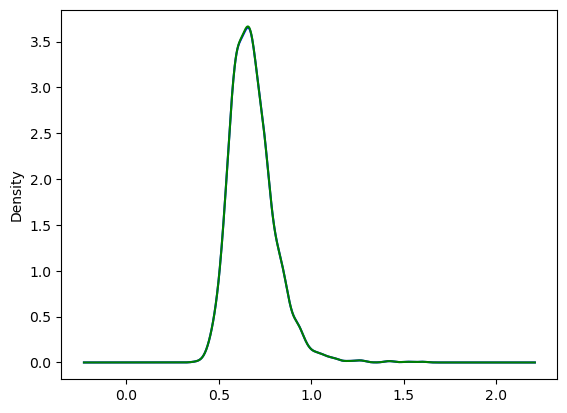

In [44]:
from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
imputer_bayes = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=10,
    random_state=42)

# let's create a MICE imputer using Bayes as estimator

imputer = IterativeImputer(
    estimator=BayesianRidge(), # the estimator to predict the NA
    initial_strategy='mean', # how will NA be imputed in step 1
    max_iter=10, # number of cycles
    imputation_order='ascending', # the order in which to impute the variables
    n_nearest_features=None, # whether to limit the number of predictors
    skip_complete=True, # whether to ignore variables without NA
    random_state=0,
)
imputer.fit(dff1)
train_t = imputer.transform(dff1)
# train_x = imputer.transform(data.iloc[:,2:])
treated = pd.DataFrame(train_t, columns=dff1.columns)
# treated = treated.apply(np.ceil)
treated.loc[:,['highest_level_of_education_qc','occupation_qc','smoking_status_c_qc']]\
      = np.round(treated.loc[:,['highest_level_of_education_qc','occupation_qc','smoking_status_c_qc']], decimals=0)

fig = plt.figure()
ax = fig.add_subplot(111)
dff1['cimt_mean_max'].plot(kind='kde', ax=ax, color='blue')
treated['cimt_mean_max'].plot(kind='kde', ax=ax, color='green')

## Expected risks

In [45]:

# target = 'MorbidityCount'

# Specify the columns of interest
columns_of_interest = ['htn_jnc7_qc', 'diabetes_status_c_qc', 'ckd_c_qc', 'cadiovascular_current'] 

# defining the outcome variable
treated['MorbidityCount'] = (treated[columns_of_interest] == 1).sum(axis = 1) # *******CHECK**********

# Min-Max Normalization
treated['normalizedOutcome'] = (treated['MorbidityCount'] - treated['MorbidityCount'].min()) / (treated['MorbidityCount'].max() - treated['MorbidityCount'].min())


# defining the expectations as mean of the target
# treated['expectation'] = treated[target_col].mean()
# treated['expectationPoisson'] = treated['normalizedOutcome'].mean()
treated['expectationPoisson'] = treated['MorbidityCount'].mean()

In [46]:
treated.shape

(1942, 28)

In [47]:
zeroCount = treated.loc[treated['MorbidityCount'] == 0]
OneCount = treated.loc[treated['MorbidityCount'] == 1]
twoCount = treated.loc[treated['MorbidityCount'] == 2]
threeCount = treated.loc[treated['MorbidityCount'] == 3]
fourCount = treated.loc[treated['MorbidityCount'] == 4]

print(len(zeroCount['MorbidityCount']), len(OneCount['MorbidityCount']), len(twoCount['MorbidityCount']), len(threeCount['MorbidityCount']), len(fourCount['MorbidityCount']))
len(OneCount['MorbidityCount'])

1194 569 147 31 1


569

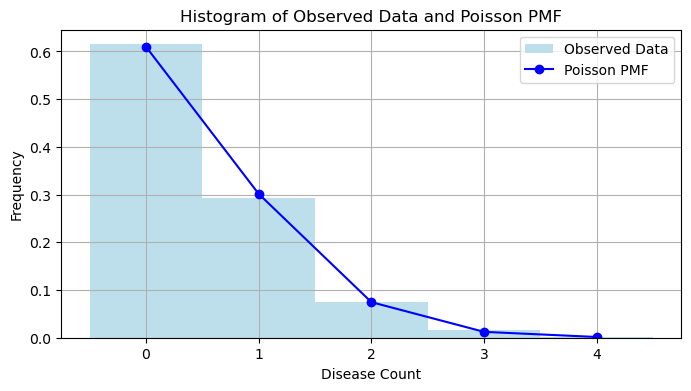

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson

# Example data
poisData = treated['MorbidityCount']

# Calculate lambda (λ) as the mean of the data
lambda_ = np.mean(poisData)

# Generate the range of possible count values (up to the max observed count)
x = np.arange(0, max(poisData) + 1)

# Calculate the Poisson probability mass function (PMF) for each count
pmf = poisson.pmf(x, lambda_)

# Plotting
plt.figure(figsize=(8, 4))
plt.hist(poisData, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, alpha=0.8, color='lightblue', label='Observed Data')
plt.plot(x, pmf, 'o-', color='blue', label='Poisson PMF')
plt.title('Histogram of Observed Data and Poisson PMF')
plt.xlabel('Disease Count')
plt.ylabel('Frequency')
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.show()


In [12]:

poisData = treated['partnership_status_c_qc']

number_of_participants = len(poisData)  # Total number of participants

# Assuming each participant contributes an equal amount of time (e.g., 1 day)
time_at_risk_per_participant = treated['partnership_status_c_qc'].mean()  # Adjust this value as per your study design

# Total person-time at risk
total_person_time = number_of_participants * time_at_risk_per_participant

# Total number of events (sum of counts)
total_events = np.sum(poisData)

# Calculating incidence density
incidence_density = total_events / total_person_time

# Print the result
print("Incidence Density:", incidence_density, "events per person-time unit")


Incidence Density: 1.0 events per person-time unit


In [11]:
np.sum(poisData)

1145

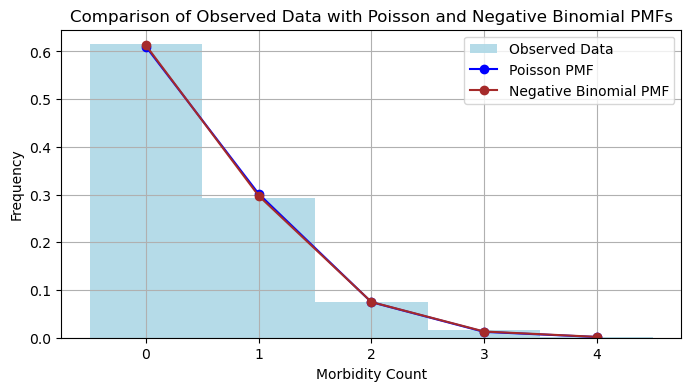

1.0181642636457031

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, nbinom

# Poisson model
lambda_poisson = np.mean(poisData)

# Calculating the mean and variance for the Negative Binomial distribution
mean_negbin = np.mean(poisData)
variance_negbin = np.var(poisData)

# The dispersion parameter (r) for the Negative Binomial distribution
# r = mean^2 / (variance - mean) for overdispersed data
r_negbin = mean_negbin**2 / (variance_negbin - mean_negbin) if variance_negbin > mean_negbin else 1

# Probability of success (p) for the Negative Binomial distribution
p_negbin = mean_negbin / variance_negbin if variance_negbin > mean_negbin else 0.5

# Generate range for count values
x = np.arange(0, max(poisData) + 1)

# Poisson PMF
pmf_poisson = poisson.pmf(x, lambda_poisson)

# cp -i -a /Users/kayadetunji/Downloads/HAALSI_work/mdscan-master/Poisson_scoring.ipynb /Users/kayadetunji/.ssh/ kayode@cream-ce.core.wits.ac.za:/spaces/freedom/kay/HAALSI_Subset_DDI.pdf  
# Negative Binomial PMF
pmf_negbin = nbinom.pmf(x, r_negbin, p_negbin)

# Plotting
plt.figure(figsize=(8,4))
plt.hist(poisData, bins=np.arange(-0.5, max(poisData) + 1.5, 1), density=True, alpha=0.9, color='lightblue', label='Observed Data')
plt.plot(x, pmf_poisson, 'o-', color='blue', label='Poisson PMF')
plt.plot(x, pmf_negbin, 'o-', color='brown', label='Negative Binomial PMF')
plt.title('Comparison of Observed Data with Poisson and Negative Binomial PMFs')
plt.xlabel('Morbidity Count')
plt.ylabel('Frequency')
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.show()

# Calculate Dispersion Statistic
dispersion_statistic = variance_negbin / mean_negbin
dispersion_statistic



In [50]:
import scipy.stats as stats

# Example data for Group 1 and Group 2
# data_group1 = np.array([1, 0, 2, 1, 3, 0, 4, 1, 0, 2])
# data_group2 = np.array([0, 1, 1,  0, 1, 1, 0])

# Example data for Group 1 and Group 2
data_group1 = np.array([1, 0])
data_group2 = np.array([1, 0, 2, 1, 3, 0, 4, 1, 0, 2])

# Min-Max Normalization
dg_norm1 = (data_group1 - data_group1.min()) / (data_group1.max() - data_group1.min())
dg_norm2 = (data_group2 - data_group2.min()) / (data_group2.max() - data_group2.min())

person_time_group1 = np.mean(data_group1)
person_time_group2 = np.mean(data_group2)

# Calculate incidence densities
incidence_density_group1 = np.sum(data_group1) / person_time_group1
incidence_density_group2 = np.sum(data_group2) / person_time_group2
# Calculate incidence densities
# incidence_density_group1 = data_group1.size / person_time_group1
# incidence_density_group2 = data_group2.size / person_time_group2

# Calculate IDR
# IDR = incidence_density_group1 / incidence_density_group2
IDR = person_time_group1 / person_time_group2

# Standard errors of the log incidence densities
se_log_id1 = np.sqrt(1 / np.sum(data_group1))
se_log_id2 = np.sqrt(1 / np.sum(data_group2))

# Standard error of the log IDR
se_log_idr = np.sqrt(se_log_id1**2 + se_log_id2**2)

# Confidence interval
z_score = stats.norm.ppf(0.975)  # For a 95% confidence interval
ci_lower = np.exp(np.log(IDR) - z_score * se_log_idr)
ci_upper = np.exp(np.log(IDR) + z_score * se_log_idr)

# Statistical significance
significance = "not significant" if ci_lower <= 1 <= ci_upper else "significant"

print(f"IDR: {IDR}")
print(f"95% Confidence Interval: [{ci_lower}, {ci_upper}]")
print(f"The difference is {significance}.")


IDR: 0.35714285714285715
95% Confidence Interval: [0.0469639552014967, 2.7159343769261235]
The difference is not significant.


In [16]:
data_group1.size

2

In [17]:

# Example data
data_group1 = np.array([1, 0, 2, 1, 3, 0, 4, 1, 0, 2])
data_group2 = np.array([0, 1, 1,  0, 1, 1, 0])

# Min-Max Normalization
dg_norm1 = (data_group1 - data_group1.min()) / (data_group1.max() - data_group1.min())
dg_norm2 = (data_group2 - data_group2.min()) / (data_group2.max() - data_group2.min())

# Total cases for each group
cases_group1 = np.sum(data_group1)
cases_group2 = np.sum(data_group2)

# Assuming equal person-time for simplicity
person_time_group1 = np.mean(data_group1)
person_time_group2 = np.mean(data_group2)

# Calculate Incidence Density for each group
incidence_density_group1 = cases_group1 / person_time_group1
incidence_density_group2 = cases_group2 / person_time_group2

# Calculate IDR
IDR = incidence_density_group1 / incidence_density_group2

# Calculate Log-IDR and its standard error
log_IDR = np.log(IDR)
SE_log_IDR = np.sqrt((1/cases_group1) + (1/cases_group2))

# Calculate 95% Confidence Interval for Log-IDR
CI_lower_log = log_IDR - 1.96 * SE_log_IDR
CI_upper_log = log_IDR + 1.96 * SE_log_IDR

# Transform the CI back to the original scale
CI_lower = np.exp(CI_lower_log)
CI_upper = np.exp(CI_upper_log)

# Z-test for significance
Z_score = log_IDR / SE_log_IDR
p_value = stats.norm.sf(abs(Z_score)) * 2  # Two-tail test

print("Incidence Density Ratio (IDR):", IDR)
print("95% Confidence Interval:", CI_lower, CI_upper)
print("Z-score:", Z_score)
print("P-value:", p_value)


Incidence Density Ratio (IDR): 1.4285714285714286
95% Confidence Interval: 0.47022658405755985 4.340070076260934
Z-score: 0.6291154670331937
P-value: 0.5292734652386912


In [51]:
# Defining the search space to be all the features except site, study_id, 
# and our created target_col and expectations columns

search_space = [col for col in treated.columns \
                if col not in \
                ['MorbidityCount', 'normalizedOutcome','site', 'study_id', 'expectationPoisson', \
                'htn_jnc7_qc', 'diabetes_status_c_qc', 'ckd_c_qc', 'cadiovascular_current']]

In [52]:
def get_str(x):
    # This function turns a pandas bin to a meaningful string
    s = str(round(x.left, 2)) + ' - ' + str(round(x.right,2))
    return s

def custom_qcut(ser, contiguous = True):
    # Get the rows that are actual numbers
    sub_ser = ser[(ser != -111) \
                     & (ser != -222) \
                     & (ser != -555) \
                     & (ser != -999)]
    
    if contiguous:
        # if contiguous, treat all the special numbers the same
        ser = ser.replace(-111 , -999)
        ser = ser.replace(-222 , -999)
        ser = ser.replace(-555 , -999)

    # Bin the actual numbers into 10 bins for scanning
    sub_ser = pd.qcut(sub_ser, 10, duplicates='drop')
    sub_ser = sub_ser.apply(get_str).astype(str)
    ser[list(sub_ser.index)] = sub_ser
    return ser
            

In [53]:
contiguous = {}
dff_2 = treated.copy()

# Create a new dataframe with the numeric columns bins     
for col in numeric_columns:
    if col in search_space:
        dff_2[col] = custom_qcut(dff_2[col].copy())
        
        bins = list(dff_2[col].unique())
        
        if -999 in bins:
            bins.remove(-999)
        
        bins = sorted(bins, key=lambda x : float(x.split(' - ')[0]))
        
        contiguous[col] = bins

In [54]:
def compress_contiguous(subset, contiguous):
    # Shorten a contiguous list e.g [0-9, 10-19] is converted to [0 - 19] 
    new = {}
    
    for col in subset:
        if col in contiguous:
            if isinstance(subset[col][0], (float,int)):
                new[col] = [str(c) for c in subset[col]]
                continue
            i = -1 if isinstance(subset[col][-1], str) else -2
            new[col] = [subset[col][0].split(' - ')[0] + ' - ' + subset[col][i].split(' - ')[-1]]
            new[col] = new[col] if i == -1 else new[col] + [str(subset[col][-1])]
        else:
            new[col] = [str(c) for c in subset[col]]
    return new

def translate_subset_to_rule(subset):
    # Print the subset as a rule for easier understanding
    desc = ''
    for key, value in subset.items():
        # desc += key + ' = {' + ' OR '.join(value) + '} AND' + '\n'
        desc += key + '{' + ' OR '.join(value) + '} AND' + ' '

    return desc[:-5].replace('_',' ').replace('{', '[').replace('}', ']')

def count_conditions(subset):
    # Split the string by 'AND' and 'OR'
    conditions = subset.replace("AND", "OR").split("OR")
    
    # Count the number of conditions
    condition_count = len(conditions)
    
    return condition_count

In [62]:
# %%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Poisson(direction='negative')
scanner = MDSS(scoring_function)
# Define a list of penalty values to loop through
penalty_values = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
# penalty_values = [0.5, 0.8, 1.0, 1.3, 1.5]
num_iters = 10
# Initialize empty lists to store results
subset_results = []
subset_results1 = []
score_results = []
size_results = []
IDR_results = []
count_results = []
z_scores = []
p_values = []
disease_counts = []
counts_percent = []
size_percent = []
dataframes = {}

# Loop through each penalty value
for penalty in penalty_values:
    # Perform the scan with the current penalty value
    subset, score = scanner.scan(dff_2[search_space], dff_2['MorbidityCount'], dff_2['expectationPoisson'], cpu=0.95,
                                 penalty=penalty, num_iters=num_iters, contiguous=contiguous.copy())
    
    to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
    temp_df = dff_2.loc[to_choose]
    size = len(temp_df)

    # Store each DataFrame in the dictionary with a unique key
    dataframes[f'df_{penalty}'] = temp_df

    # 
    expected_risk_subset = temp_df['MorbidityCount'].mean()
    expected_risk = dff_2['MorbidityCount'].mean()  
    # Total person-time at risk
    total_person_time_subset = len(temp_df) * expected_risk_subset
    total_person_time = len(dff_2) * expected_risk

    # Total number of events (sum of counts)
    total_events_subset = temp_df['MorbidityCount'].sum()
    total_events = dff_2['MorbidityCount'].sum()

    # Calculating incidence density
    # incidence_density_subset = total_events_subset / total_person_time_subset
    # incidence_density = total_events / total_person_time
    # incidence_density_subset = total_events_subset / expected_risk_subset
    # incidence_density = total_events / expected_risk
    incidence_density_subset = total_events_subset / len(temp_df)
    incidence_density = total_events / len(dff_2)

    #Calc IDR
    IDR = incidence_density_subset/incidence_density
    # IDR = expected_risk_subset/expected_risk

    # Calculate Log-IDR and its standard error
    log_IDR = np.log(IDR)
    SE_log_IDR = np.sqrt((1/total_events_subset) + (1/total_events))

    # Calculate 95% Confidence Interval for Log-IDR
    CI_lower_log = log_IDR - 1.96 * SE_log_IDR
    CI_upper_log = log_IDR + 1.96 * SE_log_IDR

    # Transform the CI back to the original scale
    CI_lower = np.exp(CI_lower_log)
    CI_upper = np.exp(CI_upper_log)

    # Z-test for significance
    Z_score = log_IDR / SE_log_IDR
    # Two-tail test
    p_value = stats.norm.sf(abs(Z_score)) * 2 

    counting = count_conditions(translate_subset_to_rule(compress_contiguous(subset, contiguous)))
    
    # Append the results to the respective lists

    # subset_results.append(subset)
    score_results.append(np.round(score, 3))
    size_percent.append(np.round((len(temp_df)/len(dff_2)*100),2))
    counts_percent.append(np.round((total_events_subset/total_events*100),2))
    size_results.append(size)
    IDR_results.append(np.round(IDR, 3))
    subset_results1.append(translate_subset_to_rule(compress_contiguous(subset, contiguous)))
    count_results.append(counting)
    z_scores.append(z_score)
    p_values.append(p_value)
    disease_counts.append(total_events_subset)

# Display the results for each penalty value
for i, penalty in enumerate(penalty_values):
    print(f"Penalty = {penalty}: Subset = {subset_results1[i]}, \nLiteralsNumber = {count_results[i]}, \nSize = {size_results[i]}, \
          IDR = {IDR_results[i]}, Score = {score_results[i]}, Z_score = {z_scores[i]}, Disease_counts = {disease_counts[i]}, \
          Size_percent = {size_percent[i]},Count_percent = {counts_percent[i]},P_value = {p_values[i]}")

Penalty = 0.5: Subset = age[40.0 - 54.0] AND cimt mean max[0.38 - 0.76] AND bmi c qc[18.95 - 25.77] AND highest level of education qc[1.0 OR 2.0] AND cholesterol 1 qc[0.55 - 5.7] AND visceral fat qc[1.48 - 5.74] AND alcohol use status c qc[0.0 OR 3.0], 
LiteralsNumber = 9, 
Size = 363,           IDR = 0.39, Score = 39.048, Z_score = 1.959963984540054, Disease_counts = 70,           Size_percent = 18.69,Count_percent = 7.29,P_value = 2.87777057515878e-14
Penalty = 1: Subset = age[40.0 - 54.0] AND cimt mean max[0.38 - 0.72] AND bmi c qc[12.97 - 25.77] AND cholesterol 1 qc[0.55 - 5.7] AND alcohol use status c qc[0.0 OR 3.0], 
LiteralsNumber = 6, 
Size = 508,           IDR = 0.482, Score = 35.774, Z_score = 1.959963984540054, Disease_counts = 121,           Size_percent = 26.16,Count_percent = 12.6,P_value = 3.766453982858989e-14
Penalty = 1.5: Subset = cimt mean max[0.38 - 0.72] AND cholesterol 1 qc[0.55 - 5.7] AND bmi c qc[12.97 - 25.77] AND alcohol use status c qc[0.0 OR 3.0] AND age[40

In [106]:
temp_df['MorbidityCount'].sum()/dff_2['MorbidityCount'].sum()*100

7.598253275109171

In [63]:
results_df = pd.DataFrame({
    'Penalty': penalty_values,
    'No of literals': count_results,
    'Subset': subset_results1,
    'Size': size_results,
    'Counts': disease_counts,
    'IDR': IDR_results,
    'Size (%)': size_percent,
    'Count (%)': counts_percent,
    'P value': p_values,
})

# Display the DataFrame
results_df

,Penalty,No of literals,Subset,Size,Counts,IDR,Size (%),Count (%),P value
0,0.5,9,age[40.0 - 54.0] AND cimt mean max[0.38 - 0.76...,363,70,0.390,18.69,7.29,2.877771e-14
1,1.0,6,age[40.0 - 54.0] AND cimt mean max[0.38 - 0.72...,508,121,0.482,26.16,12.60,3.766454e-14
2,1.5,6,cimt mean max[0.38 - 0.72] AND cholesterol 1 q...,508,121,0.482,26.16,12.60,3.766454e-14
3,2.0,6,cimt mean max[0.38 - 0.72] AND cholesterol 1 q...,508,121,0.482,26.16,12.60,3.766454e-14
4,2.5,4,bmi c qc[12.97 - 25.77] AND hdl qc[0.18 - 1.85...,842,255,0.613,43.36,26.56,3.527489e-12
5,3.0,4,bmi c qc[18.95 - 27.49] AND hdl qc[0.18 - 1.85...,401,90,0.454,20.65,9.38,7.911414e-13
6,3.5,3,bmi c qc[18.95 - 27.49] AND visceral fat qc[1....,388,87,0.454,19.98,9.06,1.655254e-12
7,4.0,3,visceral fat qc[1.48 - 4.8] AND bmi c qc[18.95...,388,87,0.454,19.98,9.06,1.655254e-12
8,4.5,3,visceral fat qc[1.48 - 4.8] AND bmi c qc[18.95...,388,87,0.454,19.98,9.06,1.655254e-12
9,5.0,3,visceral fat qc[1.48 - 4.8] AND bmi c qc[18.95...,388,87,0.454,19.98,9.06,1.655254e-12


In [ ]:
scoring_function = Poisson(direction='negative')
scanner = MDSS(scoring_function)
# Perform the scan with the current penalty value
subset, score = scanner.scan(dff_2[search_space], dff_2['MorbidityCount'], dff_2['expectationPoisson'], cpu=0.95,
                                penalty=1, num_iters=1, contiguous=contiguous.copy())
print(translate_subset_to_rule(compress_contiguous(subset, contiguous)))

to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
temp_df = dff_2.loc[to_choose]

In [ ]:
temp_df['MorbidityCount'].value_counts()

In [21]:
import numpy as np
import scipy.stats as stats

# Example data
data_group1 = dff_2['MorbidityCount']
data_group2 = temp_df['MorbidityCount']

# Total cases for each group
cases_group1 = np.sum(data_group1)
cases_group2 = np.sum(data_group2)

# Check for the Central Limit Theorem applicability (point 1)
# Rule of thumb: at least 5 to 10 events per group
clt_applicable_group1 = cases_group1 >= 5
clt_applicable_group2 = cases_group2 >= 5

# Assuming equal person-time for simplicity
person_time_group1 = dff_2['MorbidityCount'].mean()
person_time_group2 = temp_df['MorbidityCount'].mean()

# Calculate Incidence Density for each group
incidence_density_group1 = cases_group1 / person_time_group1
incidence_density_group2 = cases_group2 / person_time_group2

# Calculate IDR
IDR = incidence_density_group1 / incidence_density_group2

# Calculate Log-IDR and its standard error
log_IDR = np.log(IDR)
SE_log_IDR = np.sqrt((1/cases_group1) + (1/cases_group2))

# Calculate 95% Confidence Interval for Log-IDR
CI_lower_log = log_IDR - 1.96 * SE_log_IDR
CI_upper_log = log_IDR + 1.96 * SE_log_IDR

# Transform the CI back to the original scale
CI_lower = np.exp(CI_lower_log)
CI_upper = np.exp(CI_upper_log)

# Check for meaningful confidence intervals (point 3)
# Confidence intervals should not include negative values or be excessively wide
meaningful_ci = CI_lower > 0 and (CI_upper - CI_lower) < np.inf

# Output the results
print("Central Limit Theorem applicability in Group 1:", clt_applicable_group1)
print("Central Limit Theorem applicability in Group 2:", clt_applicable_group2)
print("Meaningful confidence interval:", meaningful_ci)
print("95% Confidence Interval:", CI_lower, CI_upper)



Central Limit Theorem applicability in Group 1: True
Central Limit Theorem applicability in Group 2: True
Meaningful confidence interval: True
95% Confidence Interval: 3.1329777314480225 3.8834646885279103


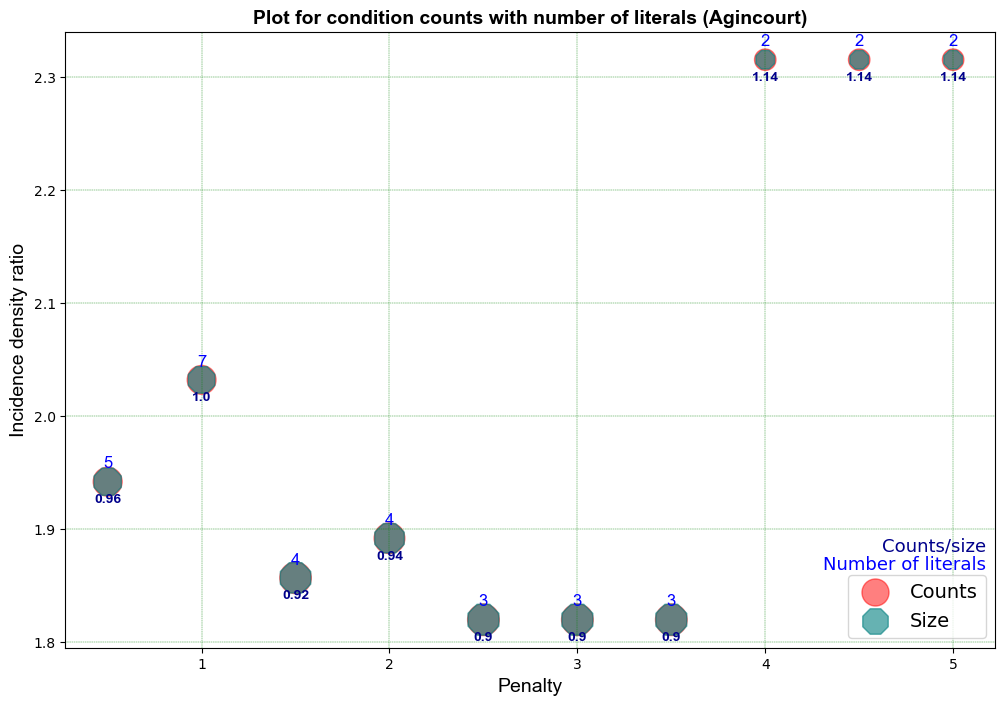

In [61]:
import matplotlib.path as mpath
# datum = {'size': [36,250,333,418,418,536,467,439,315,315],
# 'counts': [0,98,140,196,196,272,246,225,156,156],
# 'IDR': [0,0.171,0.227,0.285,0.285,0.366,0.319,0.3,0.215,0.215],
# 'scores': [25.136,23.768,25.956,24.557,23.057,20.45,14.935,15.171,14.517,14.017],
# 'literals': [6,6,5,3,3,3,2,2,1,1],
# 'penalty': [0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]
# }

df = results_df.copy()
df['count/size']=np.round(df['Counts']/df['Size'],2)

# Plotting
fig=plt.figure(figsize=(12, 8))
ax = fig.add_subplot()

# Plot Odds for Bernoulli
# plt.scatter(df['penalty'], df['IDR'], s=df['size']*2, label='Size', alpha=0.7)

# Plot counts
plt.scatter(df['Penalty'], df['IDR'], s=df['Counts']*2, marker='o', label='Counts', color='red', alpha=0.5)
# Plot size
plt.scatter(df['Penalty'], df['IDR'], s=df['Size']*2, marker='8', label='Size', color='teal', alpha=0.6)
# Plot Odds for Bernoulli
# plt.plot(df['penalty'], df['IDR'], marker='*', label='Bernoulli')

# Annotate the size values for Bernoulli
for i, txt in enumerate(df['No of literals']):
    plt.annotate(txt, (df['Penalty'][i], df['IDR'][i]), textcoords="offset points", xytext=(0,10), ha='center', fontname="Arial", fontsize=12, color='blue')

# Annotate the size values for Bernoulli
for i, txt in enumerate(df['count/size']):
    plt.annotate(txt, (df['Penalty'][i], df['IDR'][i]), textcoords="offset points", xytext=(0,-15), ha='center', fontname="Arial",fontweight="bold", color='darkblue')

# Add labels and title
plt.xlabel('Penalty', fontsize=14, fontname="Arial")
plt.ylabel('Incidence density ratio', fontsize=14, fontname="Arial")
plt.title('Plot for condition counts with number of literals (Agincourt)', fontname="Arial", fontsize=14,fontweight="bold")
plt.legend(fontsize="14",loc='lower right')
# plt.text(1, 2, 'Normal Font',  fontsize=16)
ax.text(0.99, 0.12, 'Number of literals',verticalalignment='bottom', horizontalalignment='right',transform=ax.transAxes,color='blue', fontsize=13)
ax.text(0.99, 0.15, 'Counts/size',verticalalignment='bottom', horizontalalignment='right',transform=ax.transAxes,color='darkblue', fontsize=13)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.3)
# Show the plot
plt.show()

In [ ]:
# datum = {'size': [36,250,333,418,418,536,467,439,315,315],
# 'counts': [0,98,140,196,196,272,246,225,156,156],
# 'IDR': [0,0.171,0.227,0.285,0.285,0.366,0.319,0.3,0.215,0.215],
# 'scores': [25.136,23.768,25.956,24.557,23.057,20.45,14.935,15.171,14.517,14.017],
# 'literals': [6,6,5,3,3,3,2,2,1,1],
# 'penalty': [0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]}

df = pd.DataFrame(datum)

# Plotting
fig=plt.figure(figsize=(12, 8))
ax = fig.add_subplot()

# Plot Odds for Bernoulli
# plt.scatter(df['penalty'], df['IDR'], s=df['size']*2, label='Size', alpha=0.7)

# Plot Odds for Bernoulli
plt.scatter(df['penalty'], df['IDR'], s=df['counts']*2, label='Counts', color='teal', alpha=0.6)
# Plot Odds for Bernoulli
# plt.plot(df['penalty'], df['IDR'], marker='*', label='Bernoulli')

# Annotate the size values for literals
for i, txt in enumerate(df['literals']):
    plt.annotate(txt, (df['penalty'][i], df['IDR'][i]), textcoords="offset points", xytext=(0,10), ha='center', fontname="Arial", fontsize=12, color='brown')

# Annotate the size values for counts
for i, txt in enumerate(df['counts']):
    plt.annotate(txt, (df['penalty'][i], df['IDR'][i]), textcoords="offset points", xytext=(0,-4), ha='center', fontname="Arial",fontweight="bold")

# Add labels and title
plt.xlabel('Penalty', fontsize=14, fontname="Arial")
plt.ylabel('Incidence density ratio', fontsize=14, fontname="Arial")
plt.title('Plot for disease counts with number of literals', fontname="Arial", fontsize=14,fontweight="bold")
plt.legend(fontsize="14")
# plt.text(1, 2, 'Normal Font',  fontsize=16)
ax.text(0.99, 0.88, 'Number of literals',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='brown', fontsize=13)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.3)
# Show the plot
plt.show()

In [22]:
results_df.columns

Index(['Penalty', 'No of literals', 'Subset', 'Size', 'Counts', 'IDR',
       'Size (%)', 'Count (%)', 'P value'],
      dtype='object')

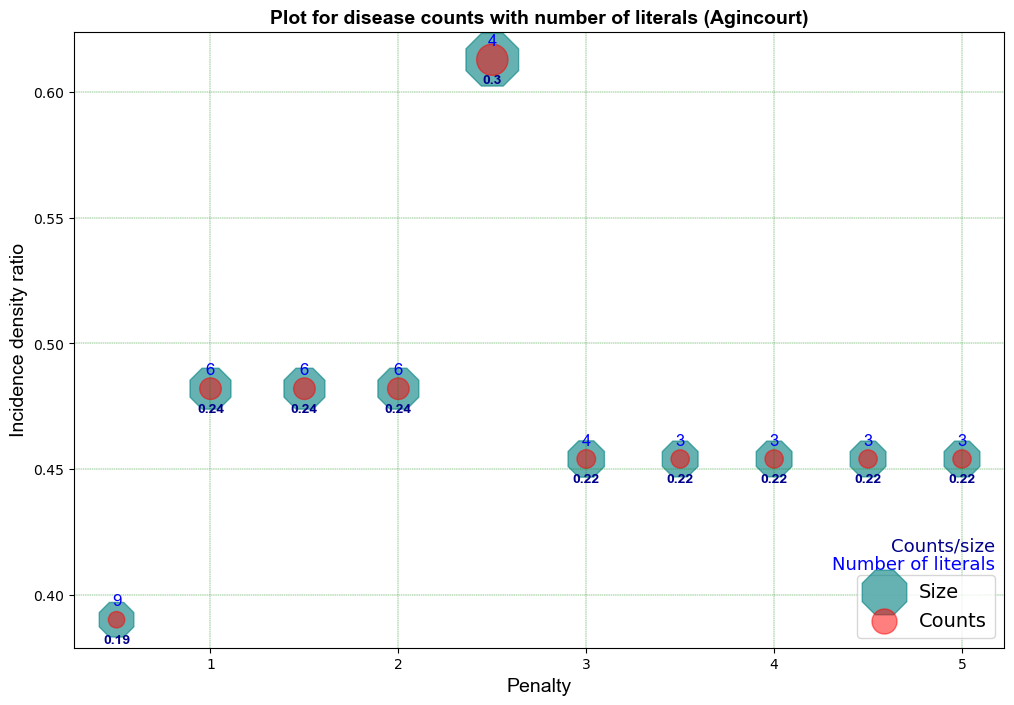

In [64]:
import matplotlib.path as mpath
from matplotlib.lines import Line2D
from matplotlib.markers import MarkerStyle
from matplotlib.transforms import Affine2D

# datum = {'size': [321,270,276,445,227,227,420,227,420,420],
# 'counts': [398,339,344,500,289,289,470,289,470,470],
# 'IDR': [0.219,0.184,0.188,0.304,0.155,0.155,0.287,0.155,0.287,0.287],
# 'scores': [32.546,28.72,26.255,23.291,24.427,23.427,19.956,21.427,17.956,16.956],
# 'literals': [8,	4,	4,	3,	2,	2,	2,	2,	2,	2],
# 'penalty': [0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]
# }

# Marker
# r'$\clubsuit$'

df = results_df.copy()
# df['size'] = np.round(df['Size']/df['Size'].sum()*100,2)
# df['counts'] = np.round(df['Counts']/df['Counts'].sum()*100,2)

# df = pd.DataFrame(datum)
df['count/size']=np.round(df['Counts']/df['Size'],2)

# Plotting
fig=plt.figure(figsize=(12, 8))
ax = fig.add_subplot()

# Plot Odds for Bernoulli
# plt.scatter(df['penalty'], df['IDR'], s=df['size']*2, label='Size', alpha=0.7)

# Plot size
plt.scatter(df['Penalty'], df['IDR'], s=df['Size']*2, marker='8', label='Size', color='teal', alpha=0.6)
# Plot counts
plt.scatter(df['Penalty'], df['IDR'], s=df['Counts']*2, marker='o', label='Counts', color='red', alpha=0.5)
# Plot Odds for Bernoulli
# plt.plot(df['penalty'], df['IDR'], marker='*', label='Bernoulli')

# Annotate the size values for Bernoulli
for i, txt in enumerate(df['No of literals']):
    plt.annotate(txt, (df['Penalty'][i], df['IDR'][i]), textcoords="offset points", xytext=(0,10), ha='center', fontname="Arial", fontsize=12, color='blue')

# Annotate the size values for Bernoulli
for i, txt in enumerate(df['count/size']):
    plt.annotate(txt, (df['Penalty'][i], df['IDR'][i]), textcoords="offset points", xytext=(0,-17), ha='center', fontname="Arial",fontweight="bold", color='darkblue')

# Add labels and title
plt.xlabel('Penalty', fontsize=14, fontname="Arial")
plt.ylabel('Incidence density ratio', fontsize=14, fontname="Arial")
plt.title('Plot for disease counts with number of literals (Agincourt)', fontname="Arial", fontsize=14,fontweight="bold")
plt.legend(fontsize="14",loc='lower right')
# plt.text(1, 2, 'Normal Font',  fontsize=16)
ax.text(0.99, 0.12, 'Number of literals',verticalalignment='bottom', horizontalalignment='right',transform=ax.transAxes,color='blue', fontsize=13)
ax.text(0.99, 0.15, 'Counts/size',verticalalignment='bottom', horizontalalignment='right',transform=ax.transAxes,color='darkblue', fontsize=13)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.3)
# Show the plot
plt.show()

In [34]:
results_df = pd.DataFrame({
    'Penalty': penalty_values,
    'No of literals': count_results,
    'Subset': subset_results1,
    'Size': size_results,
    'Counts': disease_counts,
    'IDR': IDR_results,
    'Size (%)': size_percent,
    'Count (%)': counts_percent,
    'P value': p_values,
})

# Display the DataFrame
results_df


,Penalty,No of literals,Subset,Size,Counts,IDR,Size (%),Count (%),P value
0,0.5,6,triglycerides qc[0.25 - 1.12] AND visceral fat...,36,0,0.000,2.46,0.00,NaN
1,1.0,6,cimt mean max[0.41 - 0.83] AND bmi c qc[14.53 ...,250,98,0.502,17.06,8.56,5.517345e-11
2,1.5,5,cimt mean max[0.41 - 0.68] AND friedewald ldl ...,333,140,0.538,22.73,12.23,4.349085e-12
3,2.0,3,waist circumference qc[510.0 - 950.0] AND chol...,418,196,0.600,28.53,17.12,3.857221e-11
4,2.5,3,cimt mean max[0.41 - 0.68] AND waist circumfer...,418,196,0.600,28.53,17.12,3.857221e-11
5,3.0,3,friedewald ldl c c qc[-3.31 - 2.79] AND waist ...,536,272,0.649,36.59,23.76,1.525983e-10
6,3.5,2,bmi c qc[14.53 - 26.06] AND age[40.0 - 53.0],467,246,0.674,31.88,21.48,1.972122e-08
7,4.0,2,visceral fat qc[2.82 - 5.91] AND cimt mean max...,439,225,0.656,29.97,19.65,7.199861e-09
8,4.5,1,waist circumference qc[510.0 - 780.0],315,156,0.634,21.50,13.62,8.982408e-08
9,5.0,1,waist circumference qc[510.0 - 780.0],315,156,0.634,21.50,13.62,8.982408e-08


In [65]:
results_df.to_csv('Poisson_norm_counts_neg1_NAI.csv', index=False)

In [543]:
np.unique(dataframes['df_0.5'].MorbidityCount, return_counts=True)

(array([0, 1, 2, 3, 4]), array([ 45, 176,  80,  18,   2]))

In [461]:
dataframes['df_1.5'].iloc[1:9,-3].sum()
# np.unique(dataframes['df_1.5'].iloc[1:8,-3], return_counts=True)

10

In [534]:
dataframes['df_4.5']['MorbidityCount'].value_counts().values

array([177, 121,  16,   1])

In [544]:
dataframes['df_4.5']['MorbidityCount'].value_counts()

1    210
2     99
0     91
3     18
4      2
Name: MorbidityCount, dtype: int64

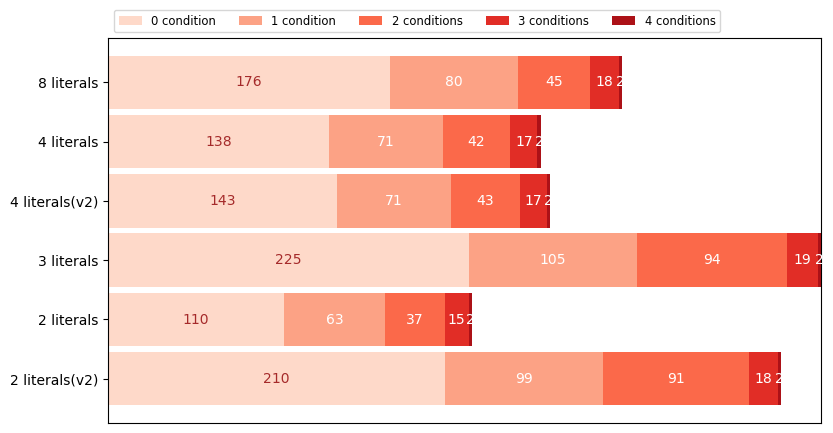

In [545]:
category_names = ['0 condition', '1 condition',
                  '2 conditions', '3 conditions', '4 conditions']
# results1 = {
#     '6 literals': [36, 0, 0, 0, 0],
#     '6 literals(v2)': [162,  78,  10, 0, 0],
#     '5 literals': [215,  96,  22, 0, 0],
#     '3 literals': [250, 140,  28, 1, 1],
#     '3 literals(v2)': [306, 189,  40,   1, 0],
#     '2 literals': [265, 160,  40,   2, 0],
#     '2 literals(v2)': [247, 161,  29,   2, 0],
#     '1 literals': [177, 121,  16,   1, 0], 
# }

results1 = {
    '8 literals': dataframes['df_0.5']['MorbidityCount'].value_counts().values,
    '4 literals': dataframes['df_1']['MorbidityCount'].value_counts().values,
    '4 literals(v2)': dataframes['df_1.5']['MorbidityCount'].value_counts().values,
    '3 literals': dataframes['df_2']['MorbidityCount'].value_counts().values,
    '2 literals': dataframes['df_2.5']['MorbidityCount'].value_counts().values, 
    '2 literals(v2)': dataframes['df_3.5']['MorbidityCount'].value_counts().values,   
}


def survey(results1, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results1.keys())
    data = np.array(list(results1.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['Reds'](
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.9,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'brown'
        ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncols=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax


survey(results1, category_names)
plt.show()

In [32]:
# Identify unique observations from the datasets
unique_ids = np.unique(np.concatenate([dataframes['df_0.5'].index, dataframes['df_1'].index, dataframes['df_2.5'].index,]))

# Create a DataFrame with values of 1 in the baseline column and 0 or 1 in the other columns
final_df = pd.DataFrame(index=unique_ids, columns=['3_literals', '2_literals', '1_literal'])

# Set values based on the presence of IDs in the datasets
# final_df['Baseline'] = 1
final_df['3_literals'] = final_df.index.isin(dataframes['df_0.5'].index).astype(int)
final_df['2_literals'] = final_df.index.isin(dataframes['df_1'].index).astype(int)
final_df['1_literal'] = final_df.index.isin(dataframes['df_2.5'].index).astype(int)

# Display the final DataFrame
print(final_df)

      3_literals  2_literals  1_literal
1              1           1          1
2              0           0          1
3              1           0          0
6              1           1          1
7              1           0          0
...          ...         ...        ...
1458           1           1          1
1459           0           1          1
1460           0           1          1
1461           1           0          0
1462           1           1          1

[684 rows x 3 columns]


In [33]:
# get coordinates where event occurs (value=1)
row_paths, col_paths = np.where(final_df.eq(1))
mask = pd.DataFrame(data= {'rows':row_paths, 'cols':col_paths})

# aggregate by row to get application's path
agg_mask = mask.groupby('rows').apply(lambda x: [x for x in x.cols])
agg_mask.tail()

rows
679    [0, 1, 2]
680       [1, 2]
681       [1, 2]
682          [0]
683    [0, 1, 2]
dtype: object

In [34]:
all_events = []

# get pair of source and target
for row in agg_mask:
    for index in range(len(row)-1):
        all_events.append([row[index], row[index+1]])
        
# create df for aggregation        
sankey_ST = pd.DataFrame(data=all_events)
sankey_ST = sankey_ST.rename(columns={0:'source', 1:'target'})
sankey_ST = sankey_ST.value_counts().reset_index()
sankey_ST = sankey_ST.rename(columns={0:'value'})

sankey_ST.head()

,source,target,value
0,1,2,227
1,0,1,152
2,0,2,43


In [35]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 15,
        thickness = 20,
        label = [f'{x}: {final_df[x].sum()}' for x in final_df.columns]
    ),
    link=dict(
        source = sankey_ST['source'],
        target = sankey_ST['target'],
        value = sankey_ST['value']
    ),
)])


fig.update_layout(title_text='Sankey plot for flow of literals', font_size=10)
fig.update_traces(textfont_size=12)
fig.show()

In [36]:
ang1_up = final_df.mask(final_df == 1, np.nan)

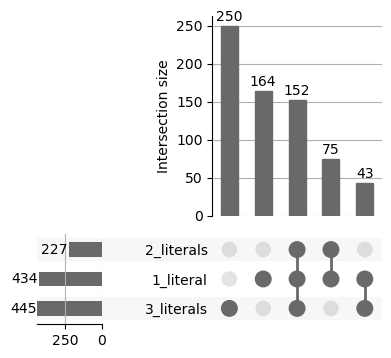

In [37]:
import upsetplot
from upsetplot import UpSet, plot, from_indicators
from upsetplot import from_contents
# angpain.values

# ang1 = angpain.set_index(angpain.pain_qc == True).set_index(angpain.pain2_qc == 1, append=True).set_index(angpain.pain_location_12_qc == 1, append=True)
# UpSet(ang1)
UpSet(from_indicators(pd.isna, data=ang1_up.iloc[:,0:]), show_counts=True, sort_by= 'cardinality', max_subset_size=1000, facecolor='dimgrey')
# upsetplot.query(ang1)
# upset = UpSet(angpain,element_size=32)

In [ ]:
# %%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Poisson(direction='negative')
scanner = MDSS(scoring_function)
# Define a list of penalty values to loop through
penalty_values = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
# penalty_values = [0.5, 0.8, 1.0, 1.3, 1.5]
num_iters = 5
# Initialize empty lists to store results
subset_results = []
subset_results1 = []
score_results = []
size_results = []
IDR_results = []
count_results = []
z_scores = []
p_values = []
disease_counts = []
size_percent = []
dataframes = {}

# Loop through each penalty value
for penalty in penalty_values:
    # Perform the scan with the current penalty value
    subset, score = scanner.scan(dff_2[search_space], dff_2['MorbidityCount'], dff_2['expectationPoisson'], cpu=0.95,
                                 penalty=penalty, num_iters=num_iters, contiguous=contiguous.copy())
    
    to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
    temp_df = dff_2.loc[to_choose]
    size = len(temp_df)

    # Store each DataFrame in the dictionary with a unique key
    dataframes[f'df_{penalty}'] = temp_df

    # 
    expected_risk_subset = temp_df['MorbidityCount'].mean()
    expected_risk = dff_2['MorbidityCount'].mean()  
    # Total person-time at risk
    total_person_time_subset = len(temp_df) * expected_risk_subset
    total_person_time = len(dff_2) * expected_risk

    # Total number of events (sum of counts)
    total_events_subset = temp_df['MorbidityCount'].sum()
    total_events = dff_2['MorbidityCount'].sum()

    # Calculating incidence density
    # incidence_density_subset = total_events_subset / total_person_time_subset
    # incidence_density = total_events / total_person_time
    incidence_density_subset = total_events_subset / expected_risk_subset
    incidence_density = total_events / expected_risk

    #Calc IDR
    IDR = incidence_density_subset/incidence_density
    # IDR = expected_risk_subset/expected_risk

    # Calculate Log-IDR and its standard error
    log_IDR = np.log(IDR)
    SE_log_IDR = np.sqrt((1/total_events_subset) + (1/total_events))

    # Calculate 95% Confidence Interval for Log-IDR
    CI_lower_log = log_IDR - 1.96 * SE_log_IDR
    CI_upper_log = log_IDR + 1.96 * SE_log_IDR

    # Transform the CI back to the original scale
    CI_lower = np.exp(CI_lower_log)
    CI_upper = np.exp(CI_upper_log)

    # Z-test for significance
    Z_score = log_IDR / SE_log_IDR
    # Two-tail test
    p_value = stats.norm.sf(abs(Z_score)) * 2 



    counting = count_conditions(translate_subset_to_rule(compress_contiguous(subset, contiguous)))
    
    # Append the results to the respective lists

    # subset_results.append(subset)
    score_results.append(np.round(score, 3))
    size_percent.append(np.round((len(temp_df)/len(dff_2)*100),2))
    size_results.append(size)
    IDR_results.append(np.round(IDR, 3))
    subset_results1.append(translate_subset_to_rule(compress_contiguous(subset, contiguous)))
    count_results.append(counting)
    z_scores.append(z_score)
    p_values.append(p_value)
    disease_counts.append(total_events_subset)

# Display the results for each penalty value
for i, penalty in enumerate(penalty_values):
    for i, penalty in enumerate(penalty_values):
        print(f"Penalty = {penalty}: Subset = {subset_results1[i]}, \nLiteralsNumber = {count_results[i]}, \nSize = {size_results[i]}, \
            IDR = {IDR_results[i]}, Score = {score_results[i]}, Z_score = {z_scores[i]}, Disease_counts = {disease_counts[i]}, \
            Size_percent = {size_percent[i]},P_value = {p_values[i]}")